# Activation Functions

Each node in a neural net has an activation function. While it is theoretically possible for each individual node to have a unique activation function, it's quite uncommon. Typically, every node in any particular layer uses the same activation function. 

Consider this image of a single node:

![](img/networkZoomMore.png)

In this case, the "activation function" is the sigmoid function. That function looks like this:

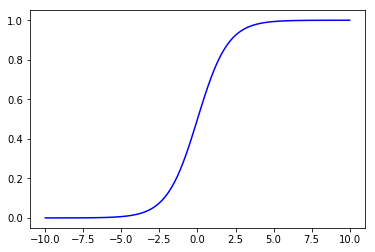

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# np.e is Euler's constant, the base of the natural logarithm 
def sigmoid(x):
    return (1 / (1 + np.exp(-x)))

# Construct a range to plot
r = np.linspace(-10, 10, 100)
plt.plot(r, sigmoid(r), 'b')
plt.show()

This function is a common choice, and is the O.G. activation function. It has some important and nice properties:

* is differentiable, which is very important because of how gradient descent and backpropogation work.
* Is bounded between 0 and 1.

It also has some problems, in particlar one of the reasons sigmoid is falling out of favor is called the vanishing gradient problem. Consider this plot with sigmoid and it's derivative:

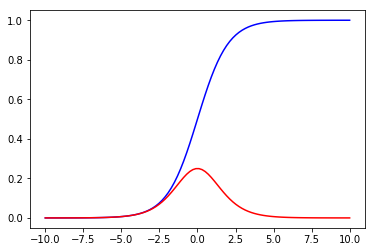

In [26]:
# Yes, it's freaky that the derivative involves the function itself. 
# Calculus is cool, but we're not going to talk about that today!
def sigmoid_prime(x):
    return sigmoid(x) * (1 - sigmoid(x))

r = np.linspace(-10, 10, 100)
plt.plot(r, sigmoid(r), 'b')
plt.plot(r, sigmoid_prime(r), 'r')
plt.show()

Notice that at both ends of the range the derivative (red line) approaches 0. In terms of tuning neural networks, this means that the corrections applied based on the loss function can become very small—causing the node to effectively stop learning. This is especially true of neural networks with several layers, because the vanishing gradient problem stacks across the layers. 

Let's examine this problem in context, this code should look familiar from previous exercises:

In [31]:
# Imports and formatting the data
# See previous lab if this is confusing
from matplotlib import pyplot as plt
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical

num_classes = 10 
image_size = 784

(training_images, training_labels), (test_images, test_labels) = mnist.load_data()
training_data = training_images.reshape(training_images.shape[0], image_size) 
test_data = test_images.reshape(test_images.shape[0], image_size)

training_labels = to_categorical(training_labels, num_classes)
test_labels = to_categorical(test_labels, num_classes)

# A helpful function we'll be using all over the place to plot training information:
def plot_training_history(history, model):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='best')

    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='best')

    plt.show()
    
    loss, accuracy  = model.evaluate(test_data, test_labels, verbose=False)
    print(f'Test loss: {loss:.3}')
    print(f'Test accuracy: {accuracy:.3}')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_59 (Dense)             (None, 5)                 3925      
_________________________________________________________________
dense_60 (Dense)             (None, 10)                60        
_________________________________________________________________
dense_61 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_62 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_63 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_64 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_65 (Dense)             (None, 10)                110       
__________

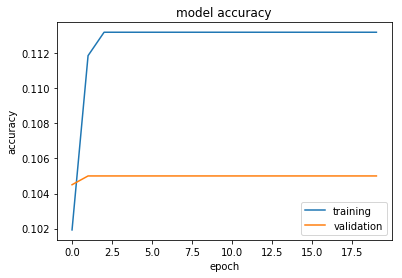

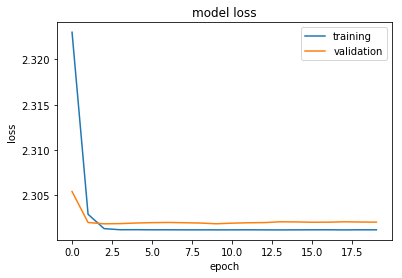

Test loss: 2.3
Test accuracy: 0.114


In [33]:
model = Sequential()
model.add(Dense(units=10, activation='sigmoid', input_shape=(image_size,)))

for _ in range(10):
    model.add(Dense(units=10, activation='sigmoid'))

model.add(Dense(units=num_classes, activation='softmax'))
model.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(training_data, training_labels, batch_size=128, epochs=20, verbose=False, validation_split=.1)
plot_training_history(history, model)

Notice that the network didn't REALLY learn anything after the first epoch... we could guess that the network is too complex, but consider this:

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_95 (Dense)             (None, 5)                 3925      
_________________________________________________________________
dense_96 (Dense)             (None, 10)                60        
_________________________________________________________________
dense_97 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_98 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_99 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_100 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_101 (Dense)            (None, 10)                110       
__________

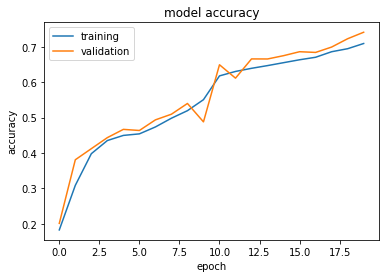

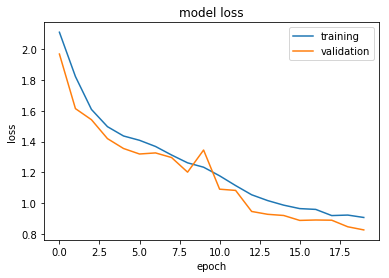

Test loss: 0.888
Test accuracy: 0.73


In [41]:
model = Sequential()
model.add(Dense(units=10, activation='relu', input_shape=(image_size,)))

for _ in range(10):
    model.add(Dense(units=10, activation='relu'))

model.add(Dense(units=num_classes, activation='softmax'))
model.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(training_data, training_labels, batch_size=128, epochs=20, verbose=False, validation_split=.1)
plot_training_history(history, model)

These results are not great, because this architecture isn't great, but changing the activation function to the Rectified Linear Unit (often called ReLU) we dramatically improved the performance of the network. This is the vanishing gradient problem rearing it's head.

Why doesn't ReLU suffer from the vanishing gradient? Let's define and plot it, the function is almost hilariously simple:

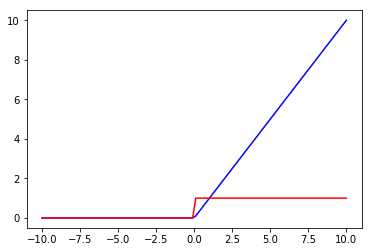

In [40]:
# This function is hard to read because we're applying it to
# numpy arrays, but for each item in x we return max(0, x[i])
def relu(x):
    return np.maximum(x, np.zeros(len(x)))

# This function is non-continuous, but the derivative can be 
# expressed as a very simple discrete function that works for
# our purpose, if x[i] > 0 return 1, else return 0:
def relu_prime(x):
    return np.array([1 if num > 0 else 0 for num in x])

# Construct a range to plot
r = np.linspace(-10, 10, 100)
plt.plot(r, relu(r), 'b')
plt.plot(r, relu_prime(r), 'r')
plt.show()

ReLU still has a kind of vanishing gradient problem, in fact the gradient can simply be 0, and once that happens the weights attached to that node will no longer be updated at all! 

The simplicity of this function servers as an important reminder about neural networks and machine learning in general: fundamentally we are combining a lot of very simple things, and repeating a simple process MANY MANY times. The result is complex, but the procecss itself is built of simple parts. 

With that in mind, brilliant machine learning specialists came up with a simple solution to ReLU's problems. They invented a function called "Leaky ReLU":

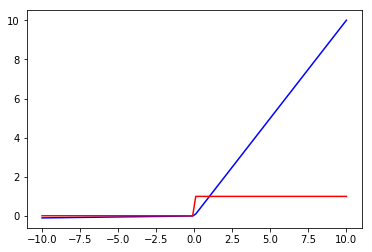

In [43]:
# For values greater than 0, leaky ReLU is the same as ReLU.
# For values less than 0, we return x[i] * 0.01 instead of just 0
# Now the gradient cannot die, because the line always has a slope.
def leaky_relu(x):
    return np.array([num if num > 0 else num * .01 for num in x])

def leaky_relu_prime(x):
    return np.array([1 if num > 0 else .01 for num in x])

r = np.linspace(-10, 10, 100)
plt.plot(r, leaky_relu(r), 'b')
plt.plot(r, leaky_relu_prime(r), 'r')
plt.show()

Leaky is not strictly better, and it can sometimes be hard to know when it will be better or not. As with many neural network tasks, the best way to prove something is empirically. Lets see if Leaky ReLU improves our 10 layer network

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_107 (Dense)            (None, 5)                 3925      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 5)                 0         
_________________________________________________________________
dense_108 (Dense)            (None, 10)                60        
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 10)                0         
_________________________________________________________________
dense_109 (Dense)            (None, 10)                110       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 10)                0         
_________________________________________________________________
dense_110 (Dense)            (None, 10)                110       
__________

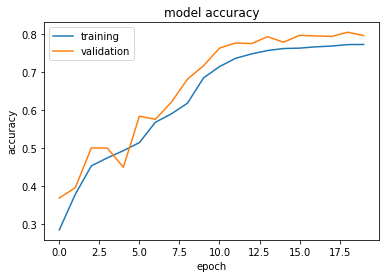

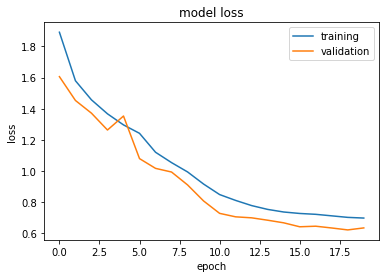

Test loss: 0.688
Test accuracy: 0.772


In [44]:
# Using Leakly ReLU is slightly different in Keras, which can be annoying.
# Additionally, Keras allows us to choose any slope we want for the "leaky" part
# rather than being statically 0.01 as in the above two functions. 
from keras.layers import LeakyReLU

model = Sequential()
model.add(Dense(units=10, input_shape=(image_size,)))
model.add(LeakyReLU(alpha=.01))

for _ in range(10):
    model.add(Dense(units=10))
    model.add(LeakyReLU(alpha=.01))

model.add(Dense(units=num_classes, activation='softmax'))
model.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(training_data, training_labels, batch_size=128, epochs=20, verbose=False, validation_split=.1)
plot_training_history(history, model)

There are other activation functions, and there is ongoing research into which ones perform best and experimenting with new activation functions. 

In addition to the vanishing and dying gradient problems, another factor in the performance of activation functions is how efficent they are to compute, and how efficent their derivatives are to compute. Remember that we're computing these functions billions of times (or more!) during training. Relu is VERY FAST to compute, and so is it's derivative. Sigmoid, tanh, and some other commonly used activations are more expensive. 

Also remember that it's not nessesary to use the same activation for every layer in a network! For example, starting with a sigmoid and following up with ReLU's can work just fine, although it is rather uncommon:

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_119 (Dense)            (None, 10)                7850      
_________________________________________________________________
dense_120 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_121 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_122 (Dense)            (None, 10)                110       
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 10)                0         
_________________________________________________________________
dense_123 (Dense)            (None, 10)                110       
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 10)                0         
__________

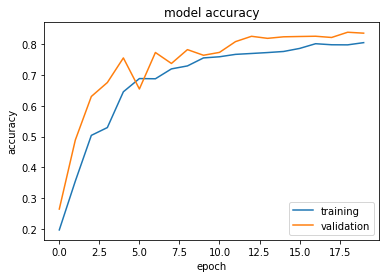

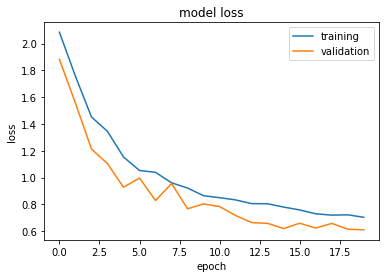

Test loss: 0.676
Test accuracy: 0.816


In [45]:
model = Sequential()

model.add(Dense(units=10, activation='sigmoid', input_shape=(image_size,)))
model.add(Dense(units=10, activation='tanh'))
model.add(Dense(units=10, activation='exponential'))

model.add(Dense(units=10))
model.add(LeakyReLU(alpha=.01))

model.add(Dense(units=10))
model.add(LeakyReLU(alpha=.05))

model.add(Dense(units=10))
model.add(LeakyReLU(alpha=.3))

model.add(Dense(units=num_classes, activation='softmax'))
model.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(training_data, training_labels, batch_size=128, epochs=20, verbose=False, validation_split=.1)
plot_training_history(history, model)

A rule of thumb: Things are changing quickly. Do some quick research before you build a new model to determine if there is a new "activation function of the week". Use that one. If it doesn't produce results, try a different one. Repeat until one works, or you have exhausted the activation functions that you know of. At that point, you may need to collect more data, change your architecture, or try a different kind of model.

At the time of this writing, one of the most popular activation functions is the Scaled Exponential Linear Unit (SELU). This activation is another modified ReLU, where the values greater than zero are still a linear function, the values below zero are an exponential curve, and the function scales the output to avoid a problem called "exploding gradient" which is the opposite of a dying or vanishing gradient:

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_126 (Dense)            (None, 10)                7850      
_________________________________________________________________
dense_127 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_128 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_129 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_130 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_131 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_132 (Dense)            (None, 10)                110       
__________

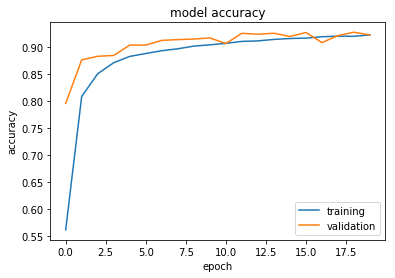

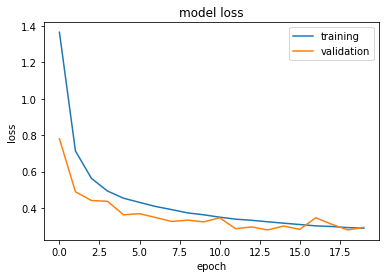

Test loss: 0.328
Test accuracy: 0.914


In [46]:
model = Sequential()
model.add(Dense(units=10, activation='selu', input_shape=(image_size,)))

for _ in range(10):
    model.add(Dense(units=10, activation='selu'))

model.add(Dense(units=num_classes, activation='softmax'))
model.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(training_data, training_labels, batch_size=128, epochs=20, verbose=False, validation_split=.1)
plot_training_history(history, model)

## The Importance of Non-Linearity

In order to satisfy the Universal Function Approximation theorem we must choose activation functions that are not strictly linear. Even ReLU counts, but if we only use linear activation functions then our neural networks, no matter how complex, can only learn to approximate linear functions themselves. See [Deep Learning and Neural Network's Chapter 5](http://neuralnetworksanddeeplearning.com/chap5.html) for a comprehensive proof of this.

## Special Cases

While many of these activation functions are "general purpose", especially in the hidden layers, there are a handful of important activation functions that serve special purposes. The softmax function is one such activation function that is widely used. 

Softmax is used to produce N output values that always sum to one. It is almost always used in the final layer of classification networks, and we interpret the results as the proababilities or confidence of our network's predictions. [Read more about softmax](https://medium.com/data-science-bootcamp/understand-the-softmax-function-in-minutes-f3a59641e86d)